## Trabajo Práctico Final
<br/>

## Curso de Especialización en Inteligencia Artificial
## Aprendizaje de Máquina II
<br/>

### Autor: Maximiliano Torti
### Fecha: 07/10/21
<br/>

# Introuducción

Este dataset fue creado y donado por ZeMA GmbH, un centro de investigación y desarrollo en mecatrónica y tecnologías de automatización ubicado en Alemania.

El dataset fue recopilado realizando ciclos de trabajo (se explicaran con detalle) sucesivos de 60 segundos de duración sobre un banco de pruebas de un circuito, midiendo las variables típicas de un procesos de este tipo (presiones, temperaturas, flujos) a la vez que se "variaba" la condición de sus componentes críticos. El objetivo es poder predecir, en base a las series de tiempo de las señales básicas, el estado de vida útil de los componentes críticos.

El banco consiste en un circuito primario de trabajo (donde circula el fluido por la máquina objetivo a lubricar o refrigerar), y un circuito secundario de enfriamiento para mantener el fluido en cierta temperatura. Los circuitos estan relacionados por un tanque común.
En la siguiente figura se puede observar el esquema de componentes.

<br />

<div style="clear: both">
<img src="img/System.png" style="width: 1000px;float:left">
</div>

<div style="clear: both">
</div>

<br />

In [1]:
import requests
import io
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import statistics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Carga y Análisis básico de datos

Los datos se encuentran almacenados en una base de datos NoSQL específica para series de tiempo llamada InfluxDB.
InfluxDB almacena y hace query de datos con el siguiente formato:

{medicion},{tag1}={valor_tag1},{tag2}={valor_tag2} {campo1}={valor_campo1},{campo2}={valor_campo2} {Timestamp}

Donde:

- Medicion es obligatorio y puede tener cualquier nombre, no tiene mayor trascendencia.
- Los tags son opcionales y permiten definir y diferenciar las series de tiempo.
- Los campos indican los valores numéricos de las curvas que componen una serie de tiempo.
- El timestamp es el tiempo del punto correspondiente.
- Tags, campos y timestamp se separan por un espacio.

Para mayor entendimiento, se agrega el siguiente ejemplo:

- system,signal=PS1,cycle=1 value=3.33 1633867200000

La query anterior se refiere a la medición system, de la serie de tiempo definidia por el campo señal igual a PS1 y ciclo igual a 1, cuya curva "value" tiene el valor 3.33 en el tiempo 1633867200000 (equivalente a 10/10/2021 12:00:00). 
Existe una cierta flexibilidad en las definiciones ya que por ejemplo "cycle" podría ser un campo en lugar de un tag. Esto depende de si cycle nos interesa como filtro o como "curva graficable".



Se utilizará el API HTTP de influxDB mediante el modulo request de python  para obtener el esquema y los metadatos de la base y luego hacer la carga de datos. Como nota, python posee un modulo conector desarrollado para influxDB que facilita ciertas tareas, pero en la práctica se observó una muy pobre performance del último con alta cantidad de datos.

In [2]:
def flux_query(q):
    INFLUX_URL='127.0.0.1'
    ORG = "Maxi"
    BUCKET_NAME = "HydraulicSystem"

    QUERY_URI='http://{}:8086/api/v2/query?org={}'.format(INFLUX_URL,ORG)
    INFLUX_TOKEN="BjUgOzZ3jhI6duhKPIOQiiNmxD7vHqrpsaPuQVSognmHfkTAyoKHtSQPiXQHz6vth2TRE922ZVb7WmeRzRJbrw=="
    headers = {}
    headers['Authorization'] = 'Token {}'.format(INFLUX_TOKEN)
    headers['Accept'] = 'application/csv'
    headers['Content-type'] = 'application/vnd.flux'
    
    response=requests.post(QUERY_URI, data=query, headers=headers)
    return pd.read_csv(io.StringIO(response.content.decode("utf-8") ), sep=",")

In [3]:
query = 'buckets()'
flux_query(query)

,Unnamed: 0,result,table,name,id,organizationID,retentionPolicy,retentionPeriod
0,NaN,_result,0,HydraulicSystem,f9c04ee080b70547,fa4591fffd923287,NaN,0
1,NaN,_result,0,_monitoring,6218701d52f4287c,fa4591fffd923287,NaN,604800000000000
2,NaN,_result,0,_tasks,afca3d3b8005bfb5,fa4591fffd923287,NaN,259200000000000


**En este caso el "bucket" (equivalente a base de datos) que exploraremos será HydraulicSystem**

In [4]:
bucket = "HydraulicSystem"

In [5]:
query = 'import "influxdata/influxdb/schema"\n\nschema.tagKeys(bucket: "{}")'.format(bucket)
flux_query(query)

,Unnamed: 0,result,table,_value
0,NaN,_result,0,_start
1,NaN,_result,0,_stop
2,NaN,_result,0,_field
3,NaN,_result,0,_measurement
4,NaN,_result,0,arch
5,NaN,_result,0,build_date
6,NaN,_result,0,commit
7,NaN,_result,0,compiler_type
8,NaN,_result,0,component
9,NaN,_result,0,cpus


**En principio los Tags en los cuales estamos interesados son signals y cycle para la entrada y component para la salida. Observemos los valores que toman**

In [6]:
signal_tag="signal"

In [7]:
query = 'import "influxdata/influxdb/schema"\n\nschema.tagValues(bucket: "{}", tag: "{}")'.format(bucket,signal_tag)
df=flux_query(query)
df

,Unnamed: 0,result,table,_value
0,NaN,_result,0,CE
1,NaN,_result,0,CP
2,NaN,_result,0,EPS1
3,NaN,_result,0,FS1
4,NaN,_result,0,FS2
5,NaN,_result,0,PS1
6,NaN,_result,0,PS2
7,NaN,_result,0,PS3
8,NaN,_result,0,PS4
9,NaN,_result,0,PS5


In [8]:
signals = list(df['_value'].values)

In [9]:
cycle_tag="cycle"

In [10]:
query = 'import "influxdata/influxdb/schema"\n\nschema.tagValues(bucket: "{}", tag: "{}")'.format(bucket,cycle_tag)
df=flux_query(query)
df

,Unnamed: 0,result,table,_value
0,NaN,_result,0,1
1,NaN,_result,0,10
2,NaN,_result,0,100
3,NaN,_result,0,1000
4,NaN,_result,0,1001
...,...,...,...,...
2200,NaN,_result,0,995
2201,NaN,_result,0,996
2202,NaN,_result,0,997
2203,NaN,_result,0,998


In [11]:
cycles_qty = max(df['_value'])

**Las query indican la presencia de 17 señales y 2205 ciclos**

**Observemos la estructura de una serie de tiempo pidiendo el primer y último punto de CE**

In [12]:
query= 'from(bucket: "{}")|> range(start:-30d)|> filter(fn: (r) => r["signal"] == "{}" and r["cycle"] == "{}")|> first()'\
        .format(bucket,signals[0],1)
flux_query(query)

,Unnamed: 0,result,table,_start,_stop,_time,_value,_field,_measurement,cycle,signal
0,NaN,_result,0,2021-09-21T21:34:14.8700237Z,2021-10-21T21:34:14.8700237Z,2021-10-06T12:00:00Z,47.202,value,system,1,CE


In [13]:
query= 'from(bucket: "{}")|> range(start:-30d)|> filter(fn: (r) => r["signal"] == "{}" and r["cycle"] == "{}")|> last()'\
        .format(bucket,signals[0],2205)
flux_query(query)

,Unnamed: 0,result,table,_start,_stop,_time,_value,_field,_measurement,cycle,signal
0,NaN,_result,0,2021-09-21T21:34:15.5046642Z,2021-10-21T21:34:15.5046642Z,2021-10-14T03:40:59Z,46.620998,value,system,2205,CE


**Cada serie definida por señal y ciclo, incluye una curva de puntos con los valores de la señal para ese ciclo.**

**El primer punto del dataset es del 06/10/2021 12:00:00 y el ultimo punto el 14/10/2021 03:40:59.**

**Ahora cargaremos una por una todas las señales de entrada**

In [19]:
signals_structure = []
for signal in signals:
    signal_array = None
    for cycle in range(1,cycles_qty+1):
        query= 'from(bucket: "{}")'\
        '|> range(start:2021-10-06T00:00:00.000Z, stop: 2021-10-15T00:00:00.000Z)'\
        '|> filter(fn: (r) => r["signal"] == "{}" and r["_field"]== "value" and r["cycle"] == "{}")'\
        .format(bucket,signal,cycle)
        
        df_signal=flux_query(query)['_value']
        
        if signal_array is None:
            signal_array = np.ones((cycles_qty,len(df_signal)))* np.nan
            
        signal_array[cycle-1]=df_signal.values
    
    signals_structure.append(signal_array)

**Repetimos lo anterior con las salidas (estado de los componentes)**

In [25]:
output_tag = "component"

In [26]:
query = 'import "influxdata/influxdb/schema"\n\nschema.tagValues(bucket: "{}", tag: "{}")'.format(bucket,output_tag)
df=flux_query(query)
df

,Unnamed: 0,result,table,_value
0,NaN,_result,0,CoolerCondition
1,NaN,_result,0,HydraulicAcumulator
2,NaN,_result,0,InternalPumpLeakage
3,NaN,_result,0,StableFlag
4,NaN,_result,0,ValveCondition


In [28]:
components = list(df['_value'].values)

In [31]:
query= 'from(bucket: "{}")|> range(start:-30d)|> filter(fn: (r) => r["component"] == "{}" and r["cycle"] == "{}")|> first()'\
        .format(bucket,components[0],1)
flux_query(query)

,Unnamed: 0,result,table,_start,_stop,_time,_value,_field,_measurement,component,cycle
0,NaN,_result,0,2021-10-04T14:38:48.1505003Z,2021-10-19T14:38:48.1505003Z,2021-10-06T12:01:00Z,3,value,system,CoolerCondition,1


In [32]:
query= 'from(bucket: "{}")|> range(start:-30d)|> filter(fn: (r) => r["component"] == "{}" and r["cycle"] == "{}")|> last()'\
        .format(bucket,components[0],1)
flux_query(query)

,Unnamed: 0,result,table,_start,_stop,_time,_value,_field,_measurement,component,cycle
0,NaN,_result,0,2021-10-04T14:39:22.9968153Z,2021-10-19T14:39:22.9968153Z,2021-10-06T12:01:00Z,3,value,system,CoolerCondition,1


**Tenemos una serie por cada componente y cada ciclo. Cada serie contiene un único punto que nos da el valor del componente en ese ciclo.**

**Ahora cargaremos todas los puntos de salida**

In [33]:
components_structure = []
for component in components:
    component_array = np.ones(cycles_qty)* np.nan
    for cycle in range(1,cycles_qty+1):
        query= 'from(bucket: "{}")'\
        '|> range(start:2021-10-06T00:00:00.000Z, stop: 2021-10-15T00:00:00.000Z)'\
        '|> filter(fn: (r) => r["component"] == "{}" and r["_field"]== "value" and r["cycle"] == "{}")'\
        .format(bucket,component,cycle)
        
        component_array[cycle-1]=flux_query(query)['_value'].values
        
    
    components_structure.append(component_array)

# Analisis básico de datos


## Señales de entrada

* Tamaño del dataset.
* Nombres de las señales.
* Tipos de datos
* Graficas
* Estadísticos básicos

### Tamaño del dataset, nombres de señales y tipos de datos

In [35]:
len(signals_structure)

17

In [36]:
for i,signal in enumerate(signals_structure):
    print("Dimensiones " + signals[i] + ": ",signal.shape, " - Tipo de dato: " , signal.dtype)

Dimensiones CE:  (2205, 60)  - Tipo de dato:  float64
Dimensiones CP:  (2205, 60)  - Tipo de dato:  float64
Dimensiones EPS1:  (2205, 6000)  - Tipo de dato:  float64
Dimensiones FS1:  (2205, 600)  - Tipo de dato:  float64
Dimensiones FS2:  (2205, 600)  - Tipo de dato:  float64
Dimensiones PS1:  (2205, 6000)  - Tipo de dato:  float64
Dimensiones PS2:  (2205, 6000)  - Tipo de dato:  float64
Dimensiones PS3:  (2205, 6000)  - Tipo de dato:  float64
Dimensiones PS4:  (2205, 6000)  - Tipo de dato:  float64
Dimensiones PS5:  (2205, 6000)  - Tipo de dato:  float64
Dimensiones PS6:  (2205, 6000)  - Tipo de dato:  float64
Dimensiones SE:  (2205, 60)  - Tipo de dato:  float64
Dimensiones TS1:  (2205, 60)  - Tipo de dato:  float64
Dimensiones TS2:  (2205, 60)  - Tipo de dato:  float64
Dimensiones TS3:  (2205, 60)  - Tipo de dato:  float64
Dimensiones TS4:  (2205, 60)  - Tipo de dato:  float64
Dimensiones VS1:  (2205, 60)  - Tipo de dato:  float64


El dataset posee la medición de 2205 ciclos de 17 señales. Cada ciclo posee 60, 600 o 6000 puntos dependiendo de la señal

Las señales de proceso medidas, entonces son:
- 6 presiones de diferentes zonas. PS1-PS6
- Potencia de bomba principal. EPS1
- Flujo de circuito primario y secundario. FS1 y FS2
- 4 temperaturas de diferentes zonas. TS1 - TS4
- Vibraciones de la bomba principal. VS1
- Eficiencia de enfriamiento. CE
- Potencia de enfriamiento. CP
- Factor de eficiencia. SE

Observamos que todas las variables son del tipo punto flotante

### Gráficas

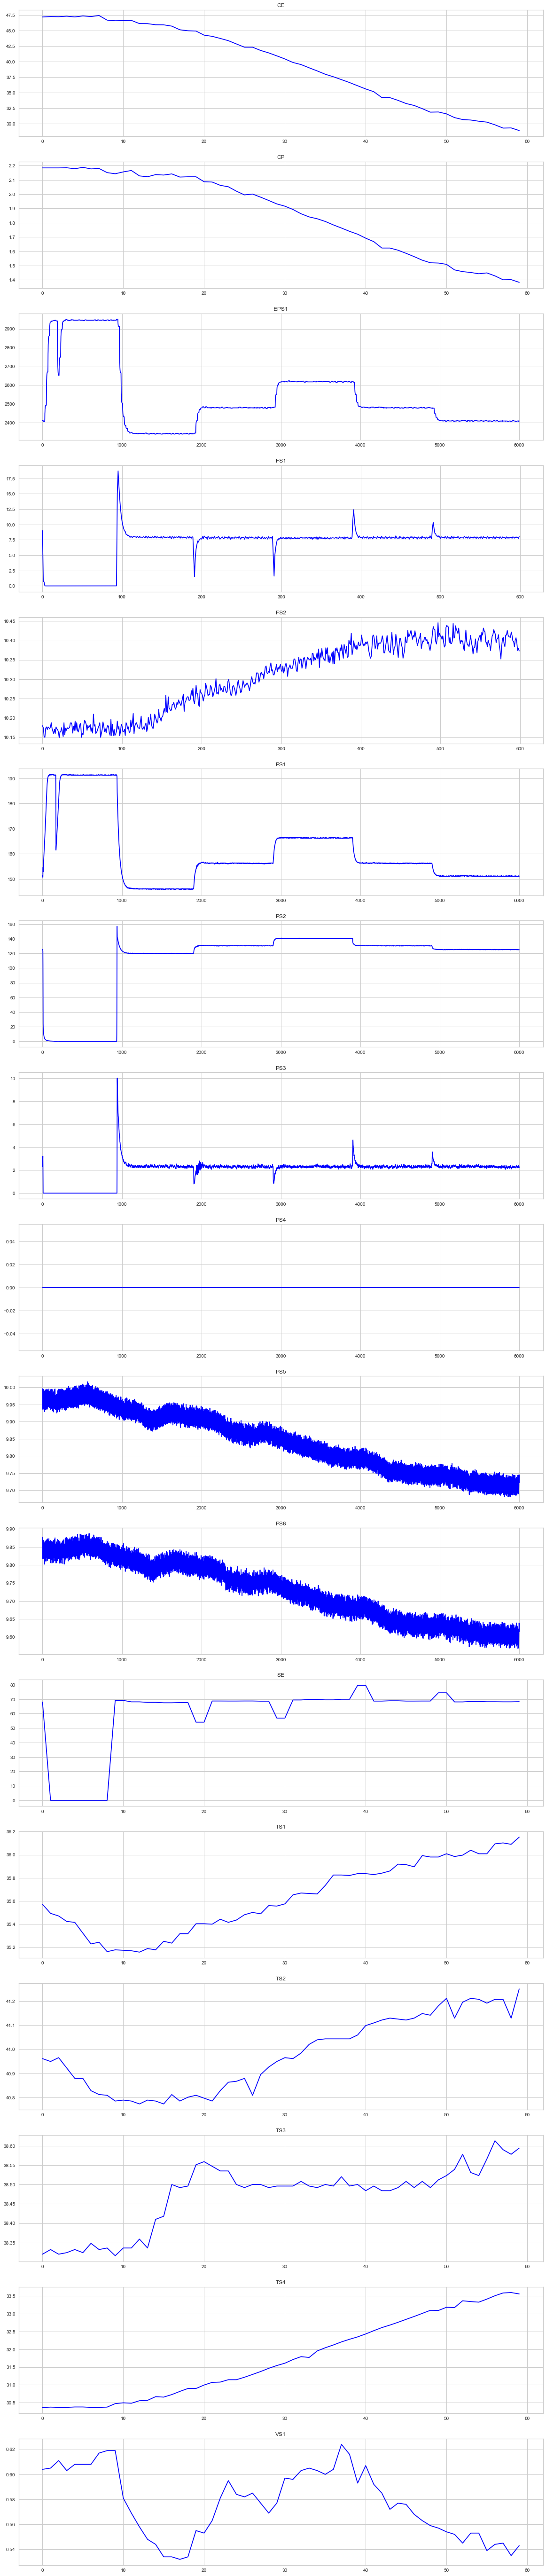

In [37]:
# Grafico de señales
fig, axs = plt.subplots(17,figsize=(20, 100))
for i,col in enumerate(signals):
    signal= signals_structure[i][0,:]
    axs[i].plot(signal,color='blue',label=None)
    axs[i].set_title(col)
    axs[i].grid(True)

**Breve explicación de las gráficas**

El ciclo de trabajo comienza en el instante 0 donde se aplica energía a la bomba MP1 (EPS1) para inyectar fluido por el circuito primario . Al estar la valvula V10 cerrada, se eleva la presión PS1 (previa a la válvula) sin elevar la presión PS2. Una vez alcanzada la presión de trabajo(en el instante 1000 aproximadamente), se abre la válvula V10 lo cual eleva la presión PS2 y disminuye PS1. A partir de este punto el fluido pasa por la máquina destino, intentando mantener el flujo (FS1) y la presión PS3 aproximadamente constante.  

Una vez que abre la válvula V10, el aceite comienza a calentarse (TS1 y TS2). En estas condiciones, el circuito secundario toma liquido del tanque y lo circula por un enfriador que desciende la temperatura de TS3 a TS4.

### Estadísticos

In [38]:
for i,col in enumerate(signals):
    print("----------------------------------------")
    print(col)
    print(f'nan: {np.sum(np.isnan(signals_structure[i]))}')
    print(f'unique: {len(np.unique(signals_structure[i]))}')
    print(f'min: {np.nanmin(signals_structure[i])}')
    print(f'max: {np.nanmax(signals_structure[i])}')
    print(f'mean: {np.nanmean(signals_structure[i])}')
    print(f'std: {np.nanstd(signals_structure[i])}')

----------------------------------------
CE
nan: 0
unique: 9395
min: 17.04199981689453
max: 48.777000427246094
mean: 31.29907714140208
std: 11.5779059411923
----------------------------------------
CP
nan: 0
unique: 1674
min: 1.0160000324249268
max: 2.9089999198913574
mean: 1.8083985042364779
std: 0.27932639579437635
----------------------------------------
EPS1
nan: 0
unique: 4404
min: 2097.800048828125
max: 2995.199951171875
mean: 2495.509224163592
std: 218.22222897201914
----------------------------------------
FS1
nan: 0
unique: 14248
min: 0.0
max: 20.47900009155273
mean: 6.198549361554204
std: 3.213825614847758
----------------------------------------
FS2
nan: 0
unique: 1486
min: 8.763999938964844
max: 10.45300006866455
mean: 9.649453043102227
std: 0.44948889975428974
----------------------------------------
PS1
nan: 0
unique: 4581
min: 133.1300048828125
max: 191.9199981689453
mean: 160.4853148787345
std: 16.13333028163704
----------------------------------------
PS2
nan: 0
unique

Observamos que no hay presencia de nan.

## Salidas
* Nombres de las señales.
* Tipos de datos
* Estadísticos
* Distribuciones

### Nombres de señales y tipos de datos

In [39]:
print(components)

['CoolerCondition', 'HydraulicAcumulator', 'InternalPumpLeakage', 'StableFlag', 'ValveCondition']


El objetivo entonces es predecir la condición de 4 componentes:
* Condición del enfriador.
* Condición de la válvula principal (V10).
* Condición de pérdidas en la bomba principal.
* Condición de pérdidas en acumulador hidráulico de reserva.

**Nota: la columna Stable Flag hace referencia a si el sistema se encuentra en operación estable y no es de interés para este trabajo por lo que se descarta** 

In [40]:
components.pop(3)
components_structure.pop(3)

array([1., 1., 1., ..., 0., 0., 0.])

In [41]:
for i,component in enumerate(components_structure):
    print("Dimensiones " + components[i] + ": ",component.shape, " - Tipo de dato: " , component.dtype)

Dimensiones CoolerCondition:  (2205,)  - Tipo de dato:  float64
Dimensiones HydraulicAcumulator:  (2205,)  - Tipo de dato:  float64
Dimensiones InternalPumpLeakage:  (2205,)  - Tipo de dato:  float64
Dimensiones ValveCondition:  (2205,)  - Tipo de dato:  float64


Las salidas parecen ser en principio del tipo numéricas. Se analiza con mayor detalle.

### Estadísticos

In [42]:
for i,col in enumerate(components):
    print("----------------------------------------")
    print(col)
    print(f'nan: {np.sum(np.isnan(components_structure[i]))}')
    print(f'unique: {len(np.unique(components_structure[i]))}')
    print(f'unique values: {np.unique(components_structure[i])}')

----------------------------------------
CoolerCondition
nan: 0
unique: 3
unique values: [  3.  20. 100.]
----------------------------------------
HydraulicAcumulator
nan: 0
unique: 4
unique values: [ 90. 100. 115. 130.]
----------------------------------------
InternalPumpLeakage
nan: 0
unique: 3
unique values: [0. 1. 2.]
----------------------------------------
ValveCondition
nan: 0
unique: 4
unique values: [ 73.  80.  90. 100.]


A pesar de ser valores numéricos, como solo hay 3 o 4 valores diferentes, es de sospechar que estos valores codifican categorías.

Estudiando el paper que da origen al dataset, se observa que efectivamente se trata de categorías:

1- Condición del enfriador: 
    
    100 -> eficiencia óptima
    
    20 -> eficiencia reducida
    
    3 -> riesgo de falla total
    
2- Condición de la válvula principal:
    
    100 -> óptima
    
    90 -> atascamiento leve
    
    80 -> atascamiento severo
    
    73 -> riesgo de falla total


3- Condición de pérdidas en la bomba principal:
    
    0 -> sin fugas
    
    1 -> fugas leves
    
    2 -> fugas severas


4- Condición de pérdidas en acumulador hidráulico de reserva:

    130 -> sin pérdidas
    
    115 -> pérdidas leves
    
    100 -> pérdidas severas
    
    90 -> riesgo de falla total

**El problema entonces se puede dividir como 4 problemas de clasificación multiclase**

In [43]:
# Mapeo valores numéricos a categorías
cooler_map = {100: 'eficiencia optima' , 20:'eficiencia reducida' ,  3:'riesgo de falla total'}
valve_map = { 100:'optima', 90:'atascamiento leve', 80: 'atascamiento severo' , 73 : 'riesgo de falla total'}
pump_map = {0:'sin fugas', 1:'fugas leves', 2:'fugas severas'}
acumulator_map = {130 :'sin perdidas', 115:'perdidas leves', 100:'perdidas severas', 90:'riesgo de falla total'}
outputs_maps= [cooler_map, acumulator_map, pump_map, valve_map]

In [44]:
df_y_cat = pd.DataFrame()
for i,col in enumerate(components):
    df_y_cat[col] = [outputs_maps[i][int(value)] for value in components_structure[i]]
df_y_cat

,CoolerCondition,HydraulicAcumulator,InternalPumpLeakage,ValveCondition
0,riesgo de falla total,sin perdidas,sin fugas,optima
1,riesgo de falla total,sin perdidas,sin fugas,optima
2,riesgo de falla total,sin perdidas,sin fugas,optima
3,riesgo de falla total,sin perdidas,sin fugas,optima
4,riesgo de falla total,sin perdidas,sin fugas,optima
...,...,...,...,...
2200,eficiencia optima,riesgo de falla total,sin fugas,optima
2201,eficiencia optima,riesgo de falla total,sin fugas,optima
2202,eficiencia optima,riesgo de falla total,sin fugas,optima
2203,eficiencia optima,riesgo de falla total,sin fugas,optima


### DIstribuciones

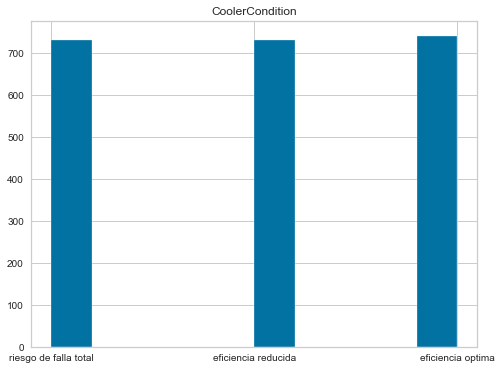

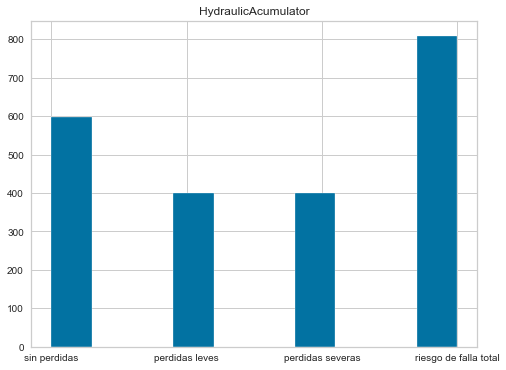

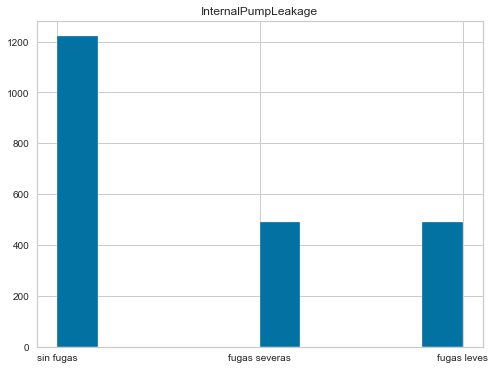

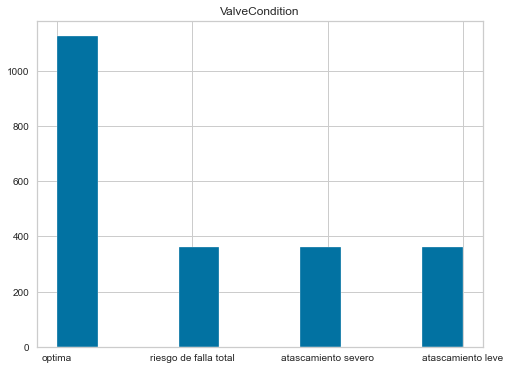

In [45]:
for col in df_y_cat.columns:
    output = df_y_cat[col]
    fig, ax = plt.subplots(1,figsize=(8,6))
    ax.hist(output)
    ax.set_title(col)

En el caso de condición de cooler y estado del acumulador las clases se encuentran balanceadas mientras que en el caso de condición de válvula y condición de bomba hay un claro desbalance de clases.

# Limpieza de datos

*   Analisis de dimensiones diferentes

## Analisis dimensiones diferentes

In [46]:
query= 'from(bucket: "{}")|> range(start:-30d)|> filter(fn: (r) => r["signal"] == "{}" and r["cycle"] == "{}")|> limit(n: 3)'\
        .format(bucket,'PS1',1)
flux_query(query)

,Unnamed: 0,result,table,_start,_stop,_time,_value,_field,_measurement,cycle,signal
0,NaN,_result,0,2021-09-21T21:35:35.0680984Z,2021-10-21T21:35:35.0680984Z,2021-10-06T12:00:00Z,151.470001,value,system,1,PS1
1,NaN,_result,0,2021-09-21T21:35:35.0680984Z,2021-10-21T21:35:35.0680984Z,2021-10-06T12:00:00.01Z,151.449997,value,system,1,PS1
2,NaN,_result,0,2021-09-21T21:35:35.0680984Z,2021-10-21T21:35:35.0680984Z,2021-10-06T12:00:00.02Z,151.520004,value,system,1,PS1


In [47]:
query= 'from(bucket: "{}")|> range(start:-30d)|> filter(fn: (r) => r["signal"] == "{}" and r["cycle"] == "{}")|> limit(n: 3)'\
        .format(bucket,'FS1',1)
flux_query(query)

,Unnamed: 0,result,table,_start,_stop,_time,_value,_field,_measurement,cycle,signal
0,NaN,_result,0,2021-09-21T21:35:36.1515182Z,2021-10-21T21:35:36.1515182Z,2021-10-06T12:00:00Z,8.990,value,system,1,FS1
1,NaN,_result,0,2021-09-21T21:35:36.1515182Z,2021-10-21T21:35:36.1515182Z,2021-10-06T12:00:00.1Z,0.770,value,system,1,FS1
2,NaN,_result,0,2021-09-21T21:35:36.1515182Z,2021-10-21T21:35:36.1515182Z,2021-10-06T12:00:00.2Z,0.641,value,system,1,FS1


In [48]:
query= 'from(bucket: "{}")|> range(start:-30d)|> filter(fn: (r) => r["signal"] == "{}" and r["cycle"] == "{}")|> limit(n: 3)'\
        .format(bucket,'TS1',1)
flux_query(query)

,Unnamed: 0,result,table,_start,_stop,_time,_value,_field,_measurement,cycle,signal
0,NaN,_result,0,2021-09-21T21:35:37.7591828Z,2021-10-21T21:35:37.7591828Z,2021-10-06T12:00:00Z,35.570000,value,system,1,TS1
1,NaN,_result,0,2021-09-21T21:35:37.7591828Z,2021-10-21T21:35:37.7591828Z,2021-10-06T12:00:01Z,35.492001,value,system,1,TS1
2,NaN,_result,0,2021-09-21T21:35:37.7591828Z,2021-10-21T21:35:37.7591828Z,2021-10-06T12:00:02Z,35.469002,value,system,1,TS1


Observamos que entre muestra y muestra hay 10 ms en PS1, 100ms en FS1 y 1s en TS1

La diferencia de dimensiones entonces se corresponde a la diferencia en las velocidades de muestreo de las señales 

* FS1 y FS2 se adquieren a una frecuencia 10 veces menor a PS1
* TS1 a TS4, VS1, SE, CE, y CP se adquieren a una frecuencia 100 veces menor a PS1.

## Tratamiento diferencias de dimensiones

Podemos submuestrear todas las señales a la frecuencia mas baja, pero perderíamos muchos datos en el proceso. Se opta por convertir a la frecuencia mas alta utilizando interpolación.

In [49]:
dt=[(col, 'f4') for col in signals]
df_x = np.zeros((2205,6000), dtype=dt)

In [50]:
for i,col in enumerate(signals):
    aux = np.ones((2205, 6000)) * np.nan
    for j in range(0,signals_structure[i].shape[1]):
        k = int(j * 6000 / signals_structure[i].shape[1])
        aux[:,k] = signals_structure[i][:,j]
    aux_df =  pd.DataFrame(aux.transpose()) 
    aux_df = aux_df.interpolate()
    aux = np.array(aux_df).transpose()
    df_x[col] = aux

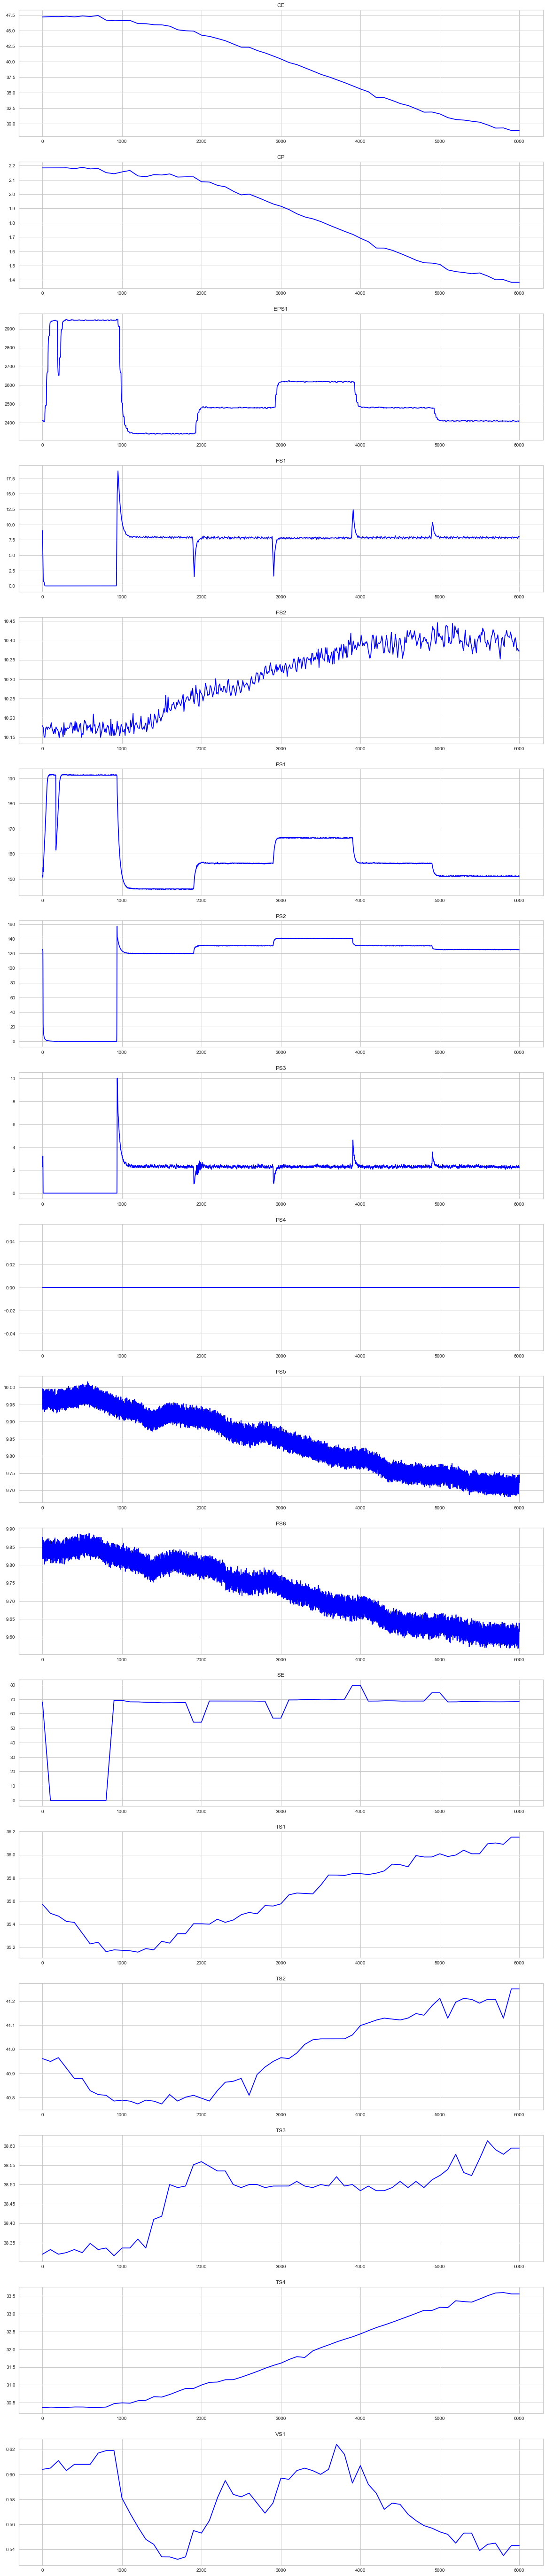

In [51]:
# Grafico nuevamente las señales
fig, axs = plt.subplots(17,figsize=(20, 100))
for i,col in enumerate(df_x.dtype.names):
    signal= df_x[col][0,:]
    axs[i].plot(signal[~np.isnan(signal)],color='blue',label=None)
    axs[i].set_title(col)
    axs[i].grid(True)

In [52]:
# Chequeo nuevas estadisticas
for col in df_x.dtype.names:
    print("----------------------------------------")
    print(col)
    print(f'nan: {np.sum(np.isnan(df_x[col]))}')
    print(f'unique: {len(np.unique(df_x[col]))}')
    print(f'min: {np.nanmin(df_x[col])}')
    print(f'max: {np.nanmax(df_x[col])}')
    print(f'mean: {np.nanmean(df_x[col])}')
    print(f'std: {np.nanstd(df_x[col])}')

----------------------------------------
CE
nan: 0
unique: 1415885
min: 17.04199981689453
max: 48.777000427246094
mean: 31.29868507385254
std: 11.577872276306152
----------------------------------------
CP
nan: 0
unique: 224343
min: 1.0160000324249268
max: 2.9089999198913574
mean: 1.8083730936050415
std: 0.2793015241622925
----------------------------------------
EPS1
nan: 0
unique: 4404
min: 2097.800048828125
max: 2995.199951171875
mean: 2495.509521484375
std: 218.2222900390625
----------------------------------------
FS1
nan: 0
unique: 228265
min: 0.0
max: 20.479000091552734
mean: 6.198060035705566
std: 3.191434383392334
----------------------------------------
FS2
nan: 0
unique: 27950
min: 8.763999938964844
max: 10.45300006866455
mean: 9.649455070495605
std: 0.4494177997112274
----------------------------------------
PS1
nan: 0
unique: 4581
min: 133.1300048828125
max: 191.9199981689453
mean: 160.48529052734375
std: 16.133323669433594
----------------------------------------
PS2
nan:

**Se corrobora que la interpolación se aplicó correctamente y no se han modificado las distribuciones**

# Esquema de validación de resultados

Particionaremos el dataset en entrenamiento y testeo (80-20). 

Sobre la partición de entrenamiento aplicaremos KFolds con 5 grupos para realizar el ajuste fino de hiperparámetros de modelo y obtener las métricas de validación.

Una vez ajustado los modelos, haremos un cálculo final de performance sobre el dataset de testeo.

In [53]:
x_train, x_test, y_train, y_test = train_test_split( df_x, df_y_cat, test_size=0.2, shuffle=True, random_state =5)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1764, 6000)
(1764, 4)
(441, 6000)
(441, 4)


# Ingeniería de features

Trabajar directamente con las señales 'raw' sería problemático debido a varias cuestiones como: gran dimensionalidad (6000 muestras por 17 señales equivalen a 102000 features), gran varianza en los valores del mismo instante de tiempo (por ruido de campo y de medición, desvíos progresivos en los sensores), gran descorrelación en valores (features) del mismo instante de tiempo (por retrasos de tiempo comunes en series de tiempo). 

Por este motivo se decide realizar la siguiente transformación:
- Se divide cada señal en 5 segmentos. El valor 5 se seleccionó en forma aleatoria y sería un hiperparámetro en el caso de querer optener el modelo con mejores resultados.

- Sobre cada segmento se aplican estadísticos. En este caso tomaremos: media, desviación estándar, oblicuidad y kurtosis. La cantidad de estadísticos tomados también se puede pensar como un hiperparámetro.


Una vez hecha la transformación pasaremos de un dataset de 2205 muestras, 6000 puntos y 17 señales a un dataset de 2205 muestras con 340 features (17 señales x 5 segmentos x 4 estadísticos). 

Sobre este dataset transformado, se harán los siguientes análisis:

* Correlaciones.
* Relación con la salida.
* plot-box de las variables mas correlacionadas con la salida

## Transformación a dataset de características

In [54]:
# Dataset de características train
df_train_char = pd.DataFrame()

n_sectors = 5
step = int(x_train.shape[1]/n_sectors)

for col in x_train.dtype.names:
    for i in range(0,n_sectors):
        df_train_char[f'Mean {i} - {col}']=np.mean(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        df_train_char[f'Std {i} - {col}']=np.std(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        df_train_char[f'Kurtosis {i} - {col}']=stats.kurtosis(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        df_train_char[f'Skew {i} - {col}']=stats.skew(x_train[col][:,(i*step):((i+1)*step)],axis=1)
        
df_train_char

<ipython-input-54-66be41dfc1b3>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_char[f'Mean {i} - {col}']=np.mean(x_train[col][:,(i*step):((i+1)*step)],axis=1)
<ipython-input-54-66be41dfc1b3>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_char[f'Std {i} - {col}']=np.std(x_train[col][:,(i*step):((i+1)*step)],axis=1)
<ipython-input-54-66be41dfc1b3>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = f

,Mean 0 - CE,Std 0 - CE,Kurtosis 0 - CE,Skew 0 - CE,Mean 1 - CE,Std 1 - CE,Kurtosis 1 - CE,Skew 1 - CE,Mean 2 - CE,Std 2 - CE,...,Kurtosis 2 - VS1,Skew 2 - VS1,Mean 3 - VS1,Std 3 - VS1,Kurtosis 3 - VS1,Skew 3 - VS1,Mean 4 - VS1,Std 4 - VS1,Kurtosis 4 - VS1,Skew 4 - VS1
0,47.825668,0.088518,-1.051072,-0.512979,48.072044,0.188978,-1.119237,0.087965,47.877499,0.123310,...,-1.479781,-0.071737,0.540889,0.011154,-0.463821,0.937507,0.526166,0.006755,-0.769083,-0.488882
1,18.646521,0.168531,-0.676778,0.234310,18.497807,0.212165,-1.777543,0.286001,18.690264,0.093547,...,1.587957,1.514389,0.767743,0.005849,-0.733490,-0.432150,0.676132,0.030648,1.361691,1.586109
2,47.279083,0.057735,1.040005,-0.855321,47.426388,0.197278,-0.877289,-0.333539,47.227489,0.127372,...,-1.016270,-0.708136,0.548643,0.015234,-0.832596,0.770902,0.540038,0.007555,-0.291133,0.480134
3,26.183615,0.084562,-0.447799,0.270768,26.494408,0.283534,-1.734736,0.058400,26.454006,0.221597,...,-0.863907,-0.106711,0.583475,0.011004,-0.350034,0.292893,0.553339,0.006089,-1.042005,0.406476
4,27.312927,0.142864,-1.620860,-0.173824,27.645443,0.201882,-1.195824,0.345368,27.512867,0.132237,...,-1.587253,0.173513,0.613022,0.015235,-0.983805,0.264462,0.594114,0.010037,0.377591,0.868202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,27.138884,0.201796,-1.248313,-0.088101,27.317955,0.085428,1.098426,-1.186942,26.980488,0.185189,...,-1.476087,0.108989,0.582635,0.011634,-1.600101,0.020172,0.553969,0.010020,-1.011897,0.044346
1760,28.101345,0.087448,0.378558,-1.160154,28.312569,0.081517,1.974170,-1.585240,28.113821,0.209015,...,-0.535241,0.805568,0.608176,0.013781,-1.380971,0.390766,0.592841,0.012856,0.123507,1.136368
1761,46.525078,0.040869,0.180817,-0.366594,46.829391,0.077978,0.074510,-0.987584,46.801270,0.099397,...,-1.714896,-0.176908,0.550975,0.012483,-1.074238,-0.063257,0.528121,0.004937,0.627350,1.096170
1762,27.281693,0.049150,4.688776,0.534722,27.693008,0.307175,-1.587583,-0.069078,27.578964,0.200992,...,-1.271669,-0.143092,0.610521,0.016847,-0.964522,0.566671,0.579257,0.010175,-0.685121,0.593136


In [55]:
# Dataset de características test
df_test_char = pd.DataFrame()

n_sectors = 5
step = int(x_test.shape[1]/n_sectors)

for col in x_test.dtype.names:
    for i in range(0,n_sectors):
        df_test_char[f'Mean {i} - {col}']=np.mean(x_test[col][:,(i*step):((i+1)*step)],axis=1)
        df_test_char[f'Std {i} - {col}']=np.std(x_test[col][:,(i*step):((i+1)*step)],axis=1)
        df_test_char[f'Kurtosis {i} - {col}']=stats.kurtosis(x_test[col][:,(i*step):((i+1)*step)],axis=1)
        df_test_char[f'Skew {i} - {col}']=stats.skew(x_test[col][:,(i*step):((i+1)*step)],axis=1)
        
df_test_char

<ipython-input-55-61702b93a7f3>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_char[f'Mean {i} - {col}']=np.mean(x_test[col][:,(i*step):((i+1)*step)],axis=1)
<ipython-input-55-61702b93a7f3>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_char[f'Std {i} - {col}']=np.std(x_test[col][:,(i*step):((i+1)*step)],axis=1)
<ipython-input-55-61702b93a7f3>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame

,Mean 0 - CE,Std 0 - CE,Kurtosis 0 - CE,Skew 0 - CE,Mean 1 - CE,Std 1 - CE,Kurtosis 1 - CE,Skew 1 - CE,Mean 2 - CE,Std 2 - CE,...,Kurtosis 2 - VS1,Skew 2 - VS1,Mean 3 - VS1,Std 3 - VS1,Kurtosis 3 - VS1,Skew 3 - VS1,Mean 4 - VS1,Std 4 - VS1,Kurtosis 4 - VS1,Skew 4 - VS1
0,47.285648,0.089551,0.606410,-1.117169,47.604916,0.182841,-1.314586,-0.253877,47.637508,0.103787,...,-1.233817,0.200669,0.554638,0.012442,-0.841033,0.618218,0.521885,0.004833,0.635651,0.546004
1,46.895473,0.086288,1.762379,-1.568768,47.368896,0.246630,-0.256549,-0.895358,47.579460,0.129101,...,-1.122386,-0.374736,0.562385,0.012214,-1.468005,0.020322,0.541425,0.006472,-1.452541,-0.111249
2,46.850101,0.106434,-0.660644,-0.840650,47.094875,0.300239,-1.470066,-0.282642,46.932674,0.133357,...,-1.477568,-0.417652,0.557752,0.012042,-0.804085,0.380122,0.535129,0.007359,-0.768460,0.081803
3,19.919050,0.187516,-1.485995,0.239205,19.729923,0.196661,-0.786147,-0.392835,19.540304,0.235989,...,-1.285037,0.180437,0.593300,0.008200,-0.490696,0.395661,0.574178,0.016164,-0.757272,0.550162
4,46.729141,0.135485,-0.248744,1.039761,47.022869,0.224420,-0.994818,-0.561840,46.904709,0.082272,...,-1.449487,-0.442618,0.561974,0.015357,-0.861857,-0.683457,0.523248,0.006849,-1.456477,0.174447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,46.521584,0.194147,-1.546016,0.487057,47.152111,0.194842,-0.752837,-0.930460,46.949070,0.153264,...,-1.610233,-0.194379,0.552640,0.013968,-1.237111,0.309554,0.533121,0.005747,-0.640462,0.518743
437,19.345219,0.279955,-1.592551,-0.352008,18.977741,0.077905,-0.404514,0.246346,18.944199,0.095766,...,-1.506806,0.145131,0.774950,0.010624,-1.524214,0.027190,0.674804,0.034018,1.252620,1.485510
438,20.879717,0.156818,0.082249,-0.036849,21.059572,0.131864,-0.928602,0.117432,20.681416,0.205891,...,-1.178229,0.038114,0.629137,0.014854,-1.584284,0.048438,0.610920,0.007446,-0.169871,0.786819
439,47.052906,0.106835,-1.020346,-0.772307,47.214504,0.173471,-1.035146,-0.182097,47.162315,0.063819,...,-1.734679,-0.315590,0.547549,0.007282,-1.489403,0.182170,0.524089,0.007363,-0.959676,-0.279904


## Correlaciones

In [56]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

corr = df_train_char.corr().abs().unstack()
labels_to_drop = get_redundant_pairs(df_train_char)
corr = corr.drop(labels=labels_to_drop).sort_values(ascending=False)

In [57]:
corr[corr>0.9]

Mean 4 - PS5       Mean 4 - PS6    0.999992
Mean 2 - PS5       Mean 2 - PS6    0.999992
Mean 3 - PS5       Mean 3 - PS6    0.999992
Mean 0 - PS5       Mean 0 - PS6    0.999992
Mean 1 - PS5       Mean 1 - PS6    0.999992
                                     ...   
Kurtosis 2 - EPS1  Std 1 - FS1     0.900241
Mean 2 - FS2       Mean 0 - PS1    0.900157
Mean 3 - CP        Mean 0 - TS2    0.900135
Mean 0 - TS1       Std 0 - TS1     0.900035
Std 0 - TS1        Mean 4 - TS3    0.900013
Length: 2616, dtype: float64

In [58]:
corr[(corr>0.6) &  (corr<0.9)]

Mean 4 - CP       Mean 4 - TS1       0.899818
Mean 0 - CP       Mean 2 - TS2       0.899805
Kurtosis 1 - FS1  Std 3 - PS2        0.899741
Kurtosis 2 - PS3  Std 4 - PS3        0.899709
Skew 1 - PS1      Std 4 - TS2        0.899612
                                       ...   
Kurtosis 4 - FS1  Std 3 - SE         0.600225
Std 3 - PS5       Mean 3 - PS6       0.600176
Skew 1 - FS1      Std 2 - FS2        0.600147
Kurtosis 1 - PS1  Kurtosis 1 - SE    0.600137
Std 3 - PS5       Mean 4 - TS4       0.600072
Length: 4628, dtype: float64

In [59]:
corr[(corr<0.6)]

Kurtosis 1 - PS3   Std 1 - VS1          0.599991
Mean 1 - PS5       Skew 1 - SE          0.599989
Std 0 - PS2        Std 1 - TS2          0.599971
Kurtosis 1 - PS5   Std 0 - TS1          0.599964
Mean 4 - PS3       Skew 1 - PS5         0.599896
                                          ...   
Std 2 - CP         Kurtosis 3 - EPS1    0.000023
Skew 3 - CP        Std 4 - VS1          0.000017
Kurtosis 4 - CP    Mean 4 - SE          0.000014
Kurtosis 0 - PS4   Std 2 - PS4          0.000005
Kurtosis 4 - EPS1  Skew 4 - TS3         0.000003
Length: 50386, dtype: float64

Observamos que dada la naturaleza de las features existe gran correlación entre muchas de ellas. En especial entre diferentes estadísticos calculados sobre el mismo segmento de la misma señal y entre el mismo estadístico calculado en el mismo segmento entre diferentes señales correlacionadas.

También se observan algunas correlaciones a priori no intuitivas como estadísticos de dos magnitudes físicas distintas, de momentos de tiempo diferentes y de circuitos diferentes (primario y secundario). Casos como estos requerirían un análisis experto del banco de prueba.

La conclusión que se obtiene de las correlaciones es que resultaría de gran beneficio hacer una selección de variables previo al entrenamiento de modelos. Esto disminuiría el costo computacional, reduciría la información redundante y mejoraría la inmunidad del modelo a ruido, ausencia de variables, entre otras cosas.

## Relación con las salidas

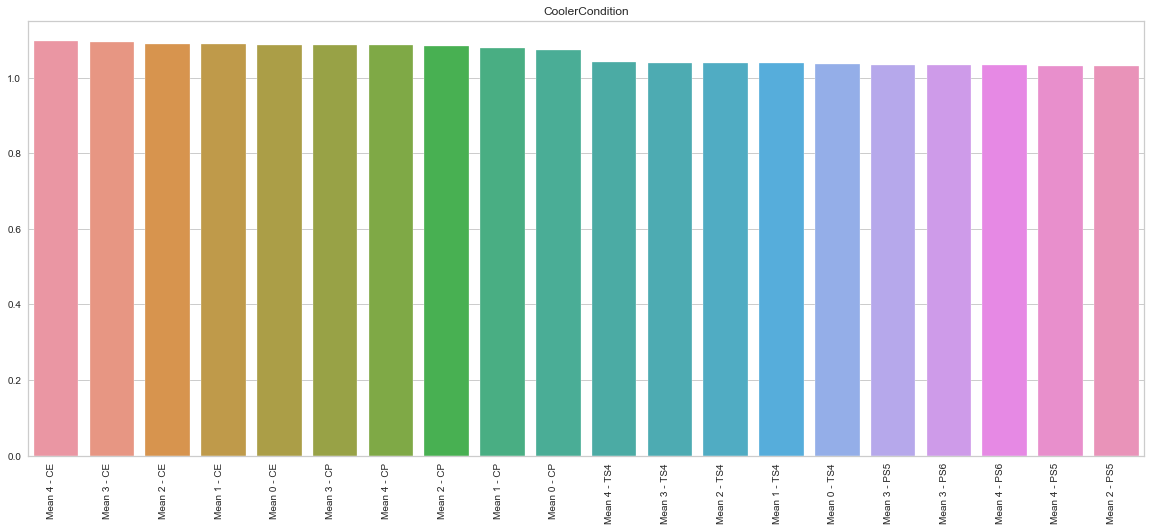

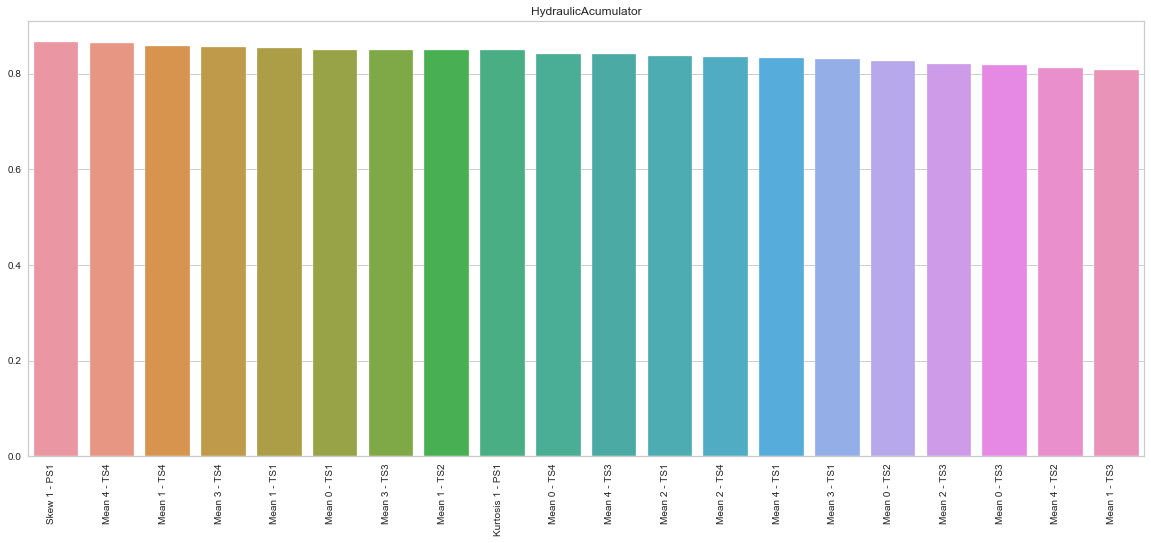

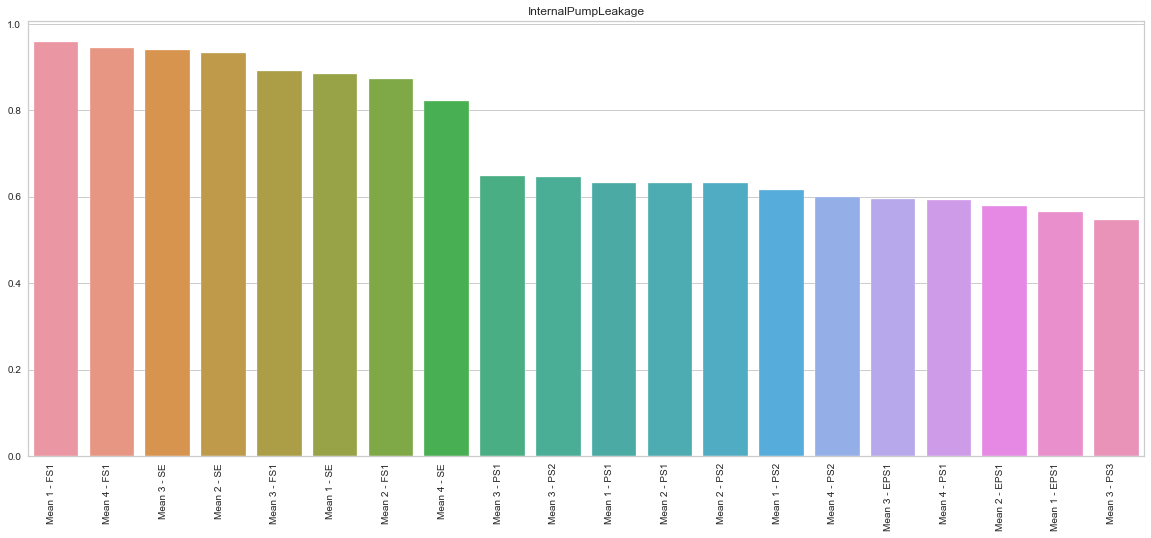

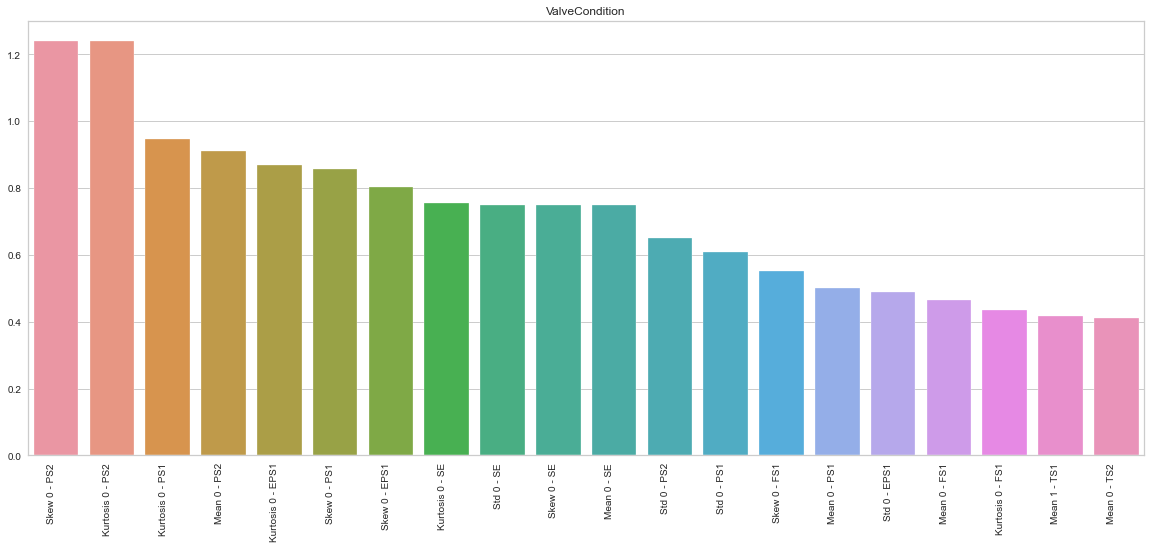

In [60]:
mutual_info_top_signals=[]

def select_features_mutual_info(X_train, y_train,k= 'all'):  
    fs = SelectKBest(score_func=mutual_info_classif, k=k )  
    fs.fit(X_train, y_train)  
    return fs

for ycol in y_train.columns:
    fs = select_features_mutual_info(df_train_char, y_train[ycol],20)
    kfeatures= np.argsort(fs.scores_)[-1:-21:-1]
    fig,axes = plt.subplots(1,1,figsize=(20,8))
    bar = sns.barplot( x = df_train_char.columns[kfeatures] , y = fs.scores_[kfeatures],ax=axes)
    bar.set_xticklabels(bar.get_xticklabels(), rotation=90, horizontalalignment='right')
    bar.set_title(ycol)
    plt.show()
    mutual_info_top_signals.append(df_train_char.columns[kfeatures])

Aplicando información mutua, se obtiene:

- Para la condición del cooler, resultan importantes la media de CE (señal "virtual") que aproxima la eficiencia del enfriamiento, la media de la potencia del enfriador y la media de la temperatura TS4. Analizando el sistema parece ser correcto.

- Para la condición de la válvula, son importantes la kurtosis y oblicuidad en el primer segmento de PS2. Esto tiene sentido,  ya que la válvula en cuestión es la que abre el circuito para que se levante presión en PS2 en el instante 1000 aproximadamente.

- Para las perdidas en la bomba principal, se marca como importante la media de FS1 que es el caudal de aceite por el circuito principal.

- Para el nivel en el acumulador de reserva, se marca como importante la oblicuidad de PS1 y las medias de las distintas temperaturas. Este correlación es dificil de interpretar contra el análisis del sistema.

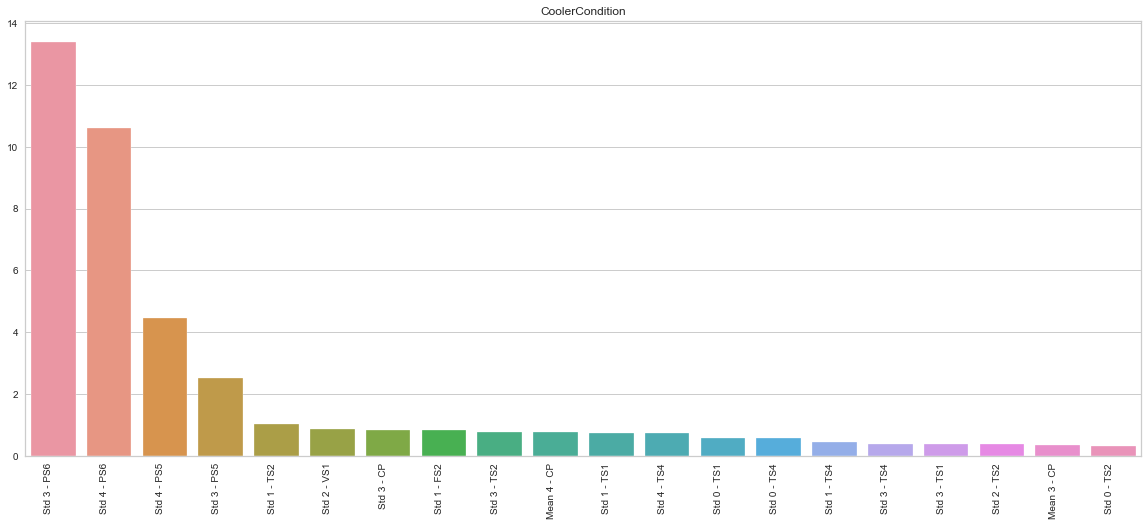

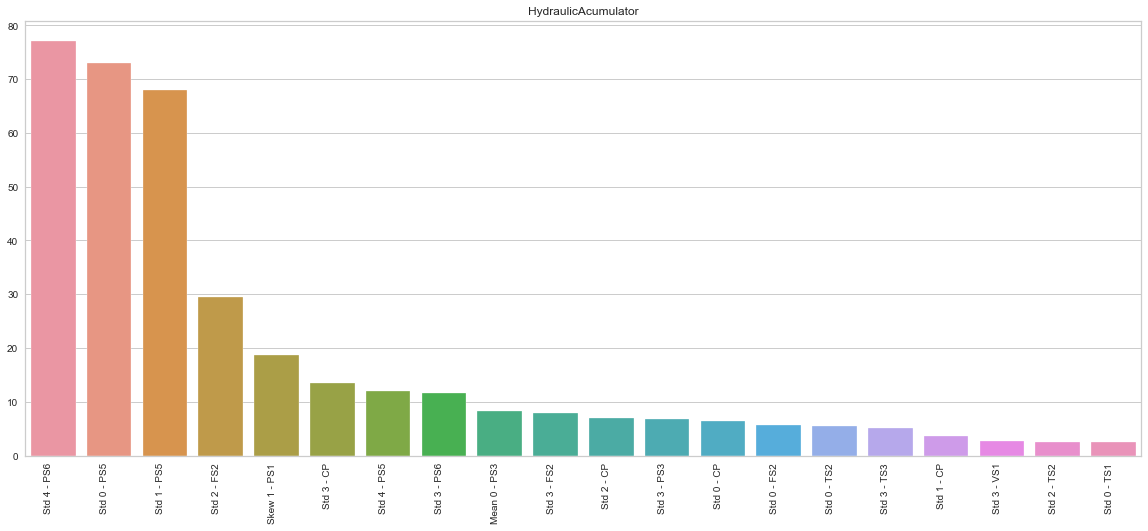

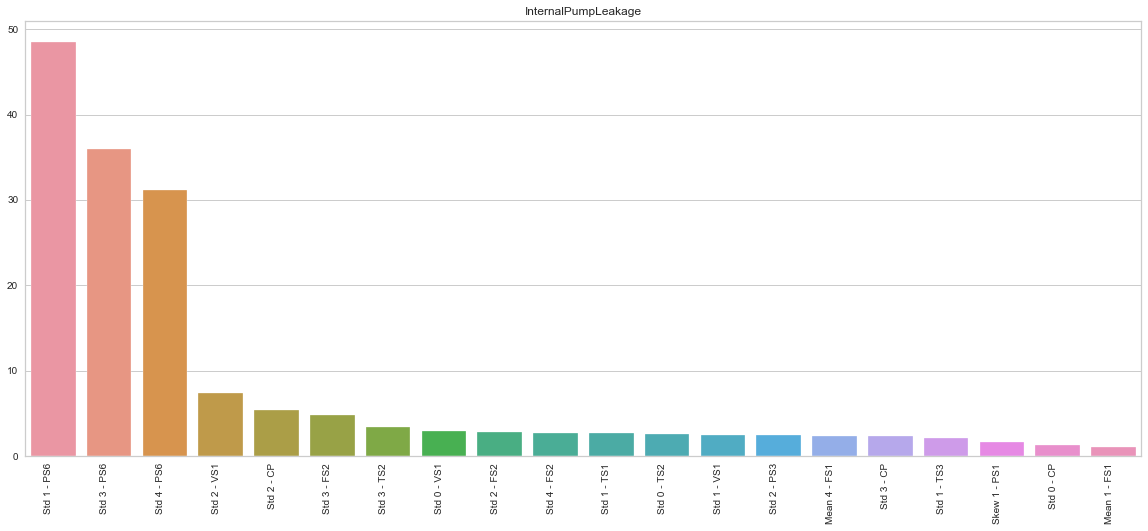

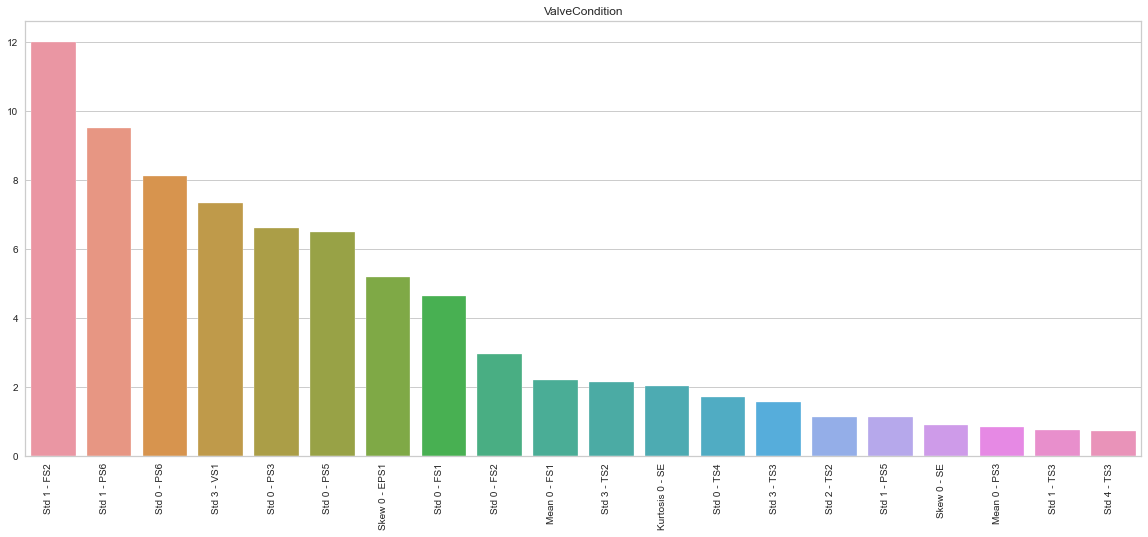

In [61]:
# Ahora utilizamos lasso para comprobar las relaciones con otro método
from sklearn.preprocessing import LabelEncoder

lasso_top_signals=[]

for ycol in y_train.columns:
    lassoreg = Lasso(alpha=0.0001,normalize=True, max_iter=10000)
    lassoreg.fit(df_train_char, LabelEncoder().fit_transform(y_train[ycol]))
    kfeatures= np.argsort(np.abs(lassoreg.coef_))[-1:-21:-1]
    fig,axes = plt.subplots(1,1,figsize=(20,8))
    bar = sns.barplot( x = df_train_char.columns[kfeatures] , y = np.abs(lassoreg.coef_[kfeatures]),ax=axes)
    bar.set_xticklabels(bar.get_xticklabels(), rotation=90, horizontalalignment='right')
    bar.set_title(ycol)
    plt.show()
    lasso_top_signals.append(df_train_char.columns[kfeatures])

Aplicando Lasso, se obtiene:

- Para la condición del cooler, resultan importantes la desviación estandar en PS5 y PS6. Se puede llegar a intuir esta correlación teniendo en cuenta que PS5 y PS6 miden la presión antes y después del cooler.

- Para la condición de la válvula, es importante la desviación en FS2 y la desviación estándar en PS5 y PS6. Esta relación no es visible en el circuito, más aún pertenecen al cirucito secundario y la válvula al primario.

- Para las perdidas en la bomba principal, se marca como importante el desvío estándar en PS6. Estas correlaciones no son visibles en el circuito físico.

- Para el nivel en el acumulador de reserva, se marca como importante la desviación estandar en PS5 y PS6. Estas correlaciones no son visibles en el circuito físico.

**A partir de lo observado, y a fin de reducir dimensiones, se decide tomar para cada salida las 10 variables de entrada más importantes marcadas por cada método**

In [62]:
top_signals=[]
for i in range(len(mutual_info_top_signals)):
    top_signals.append( np.unique(\
                                  [mutual_info_top_signals[i][0:10], \
                                   lasso_top_signals[i][0:10]]))

In [63]:
top_signals

[array(['Mean 0 - CE', 'Mean 0 - CP', 'Mean 1 - CE', 'Mean 1 - CP',
        'Mean 2 - CE', 'Mean 2 - CP', 'Mean 3 - CE', 'Mean 3 - CP',
        'Mean 4 - CE', 'Mean 4 - CP', 'Std 1 - FS2', 'Std 1 - TS2',
        'Std 2 - VS1', 'Std 3 - CP', 'Std 3 - PS5', 'Std 3 - PS6',
        'Std 3 - TS2', 'Std 4 - PS5', 'Std 4 - PS6'], dtype=object),
 array(['Kurtosis 1 - PS1', 'Mean 0 - PS3', 'Mean 0 - TS1', 'Mean 0 - TS4',
        'Mean 1 - TS1', 'Mean 1 - TS2', 'Mean 1 - TS4', 'Mean 3 - TS3',
        'Mean 3 - TS4', 'Mean 4 - TS4', 'Skew 1 - PS1', 'Std 0 - PS5',
        'Std 1 - PS5', 'Std 2 - FS2', 'Std 3 - CP', 'Std 3 - FS2',
        'Std 3 - PS6', 'Std 4 - PS5', 'Std 4 - PS6'], dtype=object),
 array(['Mean 1 - FS1', 'Mean 1 - SE', 'Mean 2 - FS1', 'Mean 2 - SE',
        'Mean 3 - FS1', 'Mean 3 - PS1', 'Mean 3 - PS2', 'Mean 3 - SE',
        'Mean 4 - FS1', 'Mean 4 - SE', 'Std 0 - VS1', 'Std 1 - PS6',
        'Std 2 - CP', 'Std 2 - FS2', 'Std 2 - VS1', 'Std 3 - FS2',
        'Std 3 - PS6', 'Std 

# Entrenamiento de modelos

Al tratarse de clasificaciones multiclase, se entrenaran modelos de regresión logística, random forest y redes neuronales. Compararemos los modelos entre si y contra un modelo base. Como métrica de comparación utilizaremos el AUC y emplearemos KFolds como mecanismo de validación.

Por ser multiclase, el AUC se computa promediando el AUC de cada clase contra el resto de las clases.

In [64]:
results = {}

In [65]:
def EvaluateKFolds(in_model, X, y, k=5):
    train_auc=0
    valid_auc=0
    
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)
    
    y = np.array(y)
    enc = OneHotEncoder(handle_unknown='ignore') 
    y_encoded = enc.fit_transform(y.reshape(-1,1)).toarray()
    
    for train_index, valid_index in kf.split(X, y):
        
        x_valid = X.iloc[valid_index]
        y_valid = y[valid_index]
        y_enc_valid = y_encoded[valid_index]
        x_train = X.iloc[train_index]
        y_train = y[train_index]
        y_enc_train = y_encoded[train_index]
        
        scaler = preprocessing.MinMaxScaler()
        
        x_train_norm = scaler.fit_transform(x_train)
        x_valid_norm = scaler.transform(x_valid)
        
        model.fit(x_train_norm, y_train)
        pred_train = model.predict_proba(x_train_norm)
        pred_valid = model.predict_proba(x_valid_norm)
        
        train_auc = train_auc + roc_auc_score(y_enc_train, pred_train,multi_class='ovr') / k
        valid_auc = valid_auc + roc_auc_score(y_enc_valid, pred_valid,multi_class='ovr') / k

    return train_auc, valid_auc

In [66]:
total_results={}
for ycol in y_train.columns:
    total_results[ycol]={}

## Modelo base

In [67]:
class RandomModel(object):

    def fit(self, X, y):
        self.yshape=len(np.unique(y))
        return None

    def predict_proba(self, X):
        return np.random.uniform(0,1, size=(X.shape[0],self.yshape))

In [68]:
results={}
for i,ycol in enumerate(y_train.columns):

    model = RandomModel()
    train_auc, valid_auc = EvaluateKFolds(model, df_train_char[top_signals[i]], y_train[ycol], 5)
    
    total_results[ycol]['Base']= {}
    total_results[ycol]['Base']["Train KFolds AUC"] = train_auc
    total_results[ycol]['Base']["Valid KFolds AUC"] = valid_auc
    
    results[ycol]={}
    results[ycol]["Train KFolds AUC"] = train_auc
    results[ycol]["Valid KFolds AUC"] = valid_auc
    
pd.DataFrame(results).T

,Train KFolds AUC,Valid KFolds AUC
CoolerCondition,0.502385,0.505984
HydraulicAcumulator,0.498960,0.511778
InternalPumpLeakage,0.503265,0.513101
ValveCondition,0.505353,0.502122


**Como era de esperarse, al ser totalmente aleatorio, el modelo base tiene un AUC de 0.5**

## RandomForest

In [69]:
results={}
for i,ycol in enumerate(y_train.columns):

    model = RandomForestClassifier(n_estimators=200, random_state=5)
    train_auc, valid_auc = EvaluateKFolds(model, df_train_char[top_signals[i]],y_train[ycol], 5)

    total_results[ycol]['Randdom Forest']= {}
    total_results[ycol]['Randdom Forest']["Train KFolds AUC"] = train_auc
    total_results[ycol]['Randdom Forest']["Valid KFolds AUC"] = valid_auc
    
    results[ycol]={}
    results[ycol]["Train KFolds AUC"] = train_auc
    results[ycol]["Valid KFolds AUC"] = valid_auc
    
pd.DataFrame(results).T

,Train KFolds AUC,Valid KFolds AUC
CoolerCondition,1.0,1.000000
HydraulicAcumulator,1.0,0.997641
InternalPumpLeakage,1.0,0.999988
ValveCondition,1.0,1.000000


El Random Forest obtuvo resultados prácticamente excelentes. Era de esperarse, ya que aproxima bien relaciones no lineales y tiene muy buena performance con datos tabulares, pero aún así excedió las espectativas. En base a esto podemos concluir que la elección de división en 5 secciones y la elección de los estadísticos fue acertada, así también la reducción de dimensiones.

## Logistic Reression

In [70]:
results={}
for i,ycol in enumerate(y_train.columns):

    model = LogisticRegression(max_iter=1000,random_state=5)
    train_auc, valid_auc = EvaluateKFolds(model, df_train_char[top_signals[i]],y_train[ycol], 5)

    total_results[ycol]['Logistic Regression']= {}
    total_results[ycol]['Logistic Regression']["Train KFolds AUC"] = train_auc
    total_results[ycol]['Logistic Regression']["Valid KFolds AUC"] = valid_auc
    
    results[ycol]={}
    results[ycol]["Train KFolds AUC"] = train_auc
    results[ycol]["Valid KFolds AUC"] = valid_auc
    
pd.DataFrame(results).T

,Train KFolds AUC,Valid KFolds AUC
CoolerCondition,0.999719,0.999716
HydraulicAcumulator,0.806061,0.797445
InternalPumpLeakage,0.942974,0.935475
ValveCondition,0.998868,0.998200


Regresión logísitca también obtuvo muy buenos resultados, lo que refuerza la idea de que la selección de divisiones y estadísiticos fue acertada.

También notamos que en el caso del acumulador hay un decenso marcado de perfromance. En este caso las relaciones no lineales deben aportar información muy valiosa, razón por la cual el random forest obtiene mejores resultados.

## Redes neuronales

Utilizaremos como redes neuronales, redes convolucionales con una arquitectura simple basada en LeNet-5.

Las redes seran entrenadas con las señales "raw". 

**El beneficio es que en este caso no debemos seleccionar el número de divisiones o los estadísticos a calcular, sino que la red neuronal aprende los mejores "filtros" por si misma.**

In [72]:
class DeepModel(object):

    def fit(self, X, y):
        
        inputs = Input(shape=(6000,17,1))
        x = Conv2D(filters=32,kernel_size=(100,1), strides=(100,1), padding="valid", activation="relu")(inputs)
        x = Conv2D(filters=32,kernel_size=(60,17), padding="valid", activation="relu")(x)
        x = Flatten()(x)
        x = Dense(units=200,activation="relu")(x)
        x = Dense(units=y.shape[1], activation="softmax")(x)
        self.model = Model(inputs, x)
        
        self.model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=AUC())
        self.model.summary()

        history=self.model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

        return history
    
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

In [73]:
results={}
for i,ycol in enumerate(y_train.columns):

    model = DeepModel()

    enc = OneHotEncoder(handle_unknown='ignore') 
    y_encoded = enc.fit_transform( np.array(y_train[ycol]).reshape(-1,1)).toarray()

    history=model.fit(x_train.view('float32').reshape(x_train.shape + (-1,1)), y_encoded)

    total_results[ycol]['DeepModel']= {}
    total_results[ycol]['DeepModel']["Train KFolds AUC"] = history.history[list(history.history)[1]][-1]
    total_results[ycol]['DeepModel']["Valid KFolds AUC"] = history.history[list(history.history)[3]][-1]
    
    results[ycol]={}
    results[ycol]["Train KFolds AUC"] = history.history[list(history.history)[1]][-1]
    results[ycol]["Valid KFolds AUC"] = history.history[list(history.history)[3]][-1]


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000, 17, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 17, 32)        3232      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 32)          1044512   
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 200)               6600      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 1,054,947
Trainable params: 1,054,947
Non-trainable params: 0
____________________________________________

45/45 [==============================] - 1s 25ms/step - loss: 17.2599 - auc_3: 0.6974 - val_loss: 0.4823 - val_auc_3: 0.9929
Epoch 2/10
45/45 [==============================] - 1s 17ms/step - loss: 0.1308 - auc_3: 0.9997 - val_loss: 0.0119 - val_auc_3: 1.0000
Epoch 3/10
45/45 [==============================] - 1s 17ms/step - loss: 0.0954 - auc_3: 0.9980 - val_loss: 0.0021 - val_auc_3: 1.0000
Epoch 4/10
45/45 [==============================] - 1s 16ms/step - loss: 0.0013 - auc_3: 1.0000 - val_loss: 8.3877e-04 - val_auc_3: 1.0000
Epoch 5/10
45/45 [==============================] - 1s 16ms/step - loss: 7.5449e-04 - auc_3: 1.0000 - val_loss: 5.7505e-04 - val_auc_3: 1.0000
Epoch 6/10
45/45 [==============================] - 1s 17ms/step - loss: 5.4048e-04 - auc_3: 1.0000 - val_loss: 4.3278e-04 - val_auc_3: 1.0000
Epoch 7/10
45/45 [==============================] - 1s 17ms/step - loss: 4.1679e-04 - auc_3: 1.0000 - val_loss: 3.4166e-04 - val_auc_3: 1.0000
Epoch 8/10
45/45 [===================

In [74]:
pd.DataFrame(results).T

,Train KFolds AUC,Valid KFolds AUC
CoolerCondition,0.980580,0.983306
HydraulicAcumulator,0.808463,0.809118
InternalPumpLeakage,0.795570,0.811844
ValveCondition,1.000000,1.000000


Observamos muy buenos resultados en condición de cooler y de válvula pero regular en acumulador y pérdidas

### Hiperparameter Tunning

Dado que el beneficio de las redes neuronales de no tener que seleccionar el número de segmentos y los estadísticos es muy atractivo, queremos mejorar su performance sobre los componentes acumulador y pérdidas en bomba principal aplicando "hiperparameter tunning".

In [75]:
def HT_Model(conv_filters=32, kernel_size=100, activation= 'relu', dense_units= 5, out_units=1, summary=False):
    
    inputs = Input(shape=(6000,17,1))
    x = Conv2D(filters=conv_filters, kernel_size=(kernel_size,1), strides=(kernel_size,1),
                padding="valid", activation=activation)(inputs)
    x = Conv2D(filters=conv_filters, kernel_size=(int(6000/kernel_size),17), padding="valid", activation=activation)(x)
    x = Flatten()(x)
    x = Dense(units=dense_units,activation=activation)(x)
    x = Dense(units=out_units, activation="softmax")(x)
    model = Model(inputs, x)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[AUC(),'accuracy'])
    if summary:
        model.summary()
    return model

In [76]:
best_params = []

In [77]:
for col in ['InternalPumpLeakage']:

    enc = OneHotEncoder(handle_unknown='ignore') 
    y_encoded = enc.fit_transform( np.array(y_train[col]).reshape(-1,1)).toarray()

    # Definying grid parameters
    conv_filters = [32, 64, 128]
    kernel_size = [100, 200, 500, 1000, 2000]
    activation = ['sigmoid','relu', 'tanh']
    dense_units = [100, 200]
    out_units = [y_encoded.shape[1]]

    param_grid = dict(conv_filters = conv_filters,  
                      kernel_size = kernel_size,
                      activation = activation,
                      dense_units = dense_units,
                      out_units = out_units)
    
    clf = KerasClassifier(build_fn= HT_Model, epochs= 10, batch_size=32, verbose= 0)
    model = RandomizedSearchCV(estimator= clf, n_iter=30, param_distributions=param_grid)
    model.fit(x_train.view('float32').reshape(x_train.shape + (-1,1)), y_encoded)
    best_params.append(model.best_params_)
    print("Best params "+col+": {}".format(model.best_params_))

Best params InternalPumpLeakage: {'out_units': 3, 'kernel_size': 200, 'dense_units': 200, 'conv_filters': 64, 'activation': 'relu'}


In [79]:
for col in ['HydraulicAcumulator']:

    enc = OneHotEncoder(handle_unknown='ignore') 
    y_encoded = enc.fit_transform( np.array(y_train[col]).reshape(-1,1)).toarray()

    # Definying grid parameters
    conv_filters = [32, 64, 128]
    kernel_size = [100, 200, 500, 1000, 2000]
    activation = ['sigmoid','relu', 'tanh']
    dense_units = [100, 200]
    out_units = [y_encoded.shape[1]]

    param_grid = dict(conv_filters = conv_filters,  
                      kernel_size = kernel_size,
                      activation = activation,
                      dense_units = dense_units,
                      out_units = out_units)
    
    clf = KerasClassifier(build_fn= HT_Model, epochs= 10, batch_size=32, verbose= 0)
    model = RandomizedSearchCV(estimator= clf, n_iter=30, param_distributions=param_grid)
    model.fit(x_train.view('float32').reshape(x_train.shape + (-1,1)), y_encoded)
    best_params.append(model.best_params_)
    print("Best params "+col+": {}".format(model.best_params_))

Best params HydraulicAcumulator: {'out_units': 4, 'kernel_size': 100, 'dense_units': 200, 'conv_filters': 32, 'activation': 'relu'}


In [80]:
results={}
for i,ycol in enumerate(['InternalPumpLeakage','HydraulicAcumulator']):

    model = HT_Model ( **(best_params[i]))

    enc = OneHotEncoder(handle_unknown='ignore') 
    y_encoded = enc.fit_transform( np.array(y_train[ycol]).reshape(-1,1)).toarray()

    history=model.fit(x_train.view('float32').reshape(x_train.shape + (-1,1)), y_encoded,
                      epochs=10, batch_size=32, validation_split=0.2)

    total_results[ycol]['DeepModel with Tunning']= {}
    total_results[ycol]['DeepModel with Tunning']["Train KFolds AUC"] = history.history[list(history.history)[1]][-1]
    total_results[ycol]['DeepModel with Tunning']["Valid KFolds AUC"] = history.history[list(history.history)[4]][-1]
    
    results[ycol]={}
    results[ycol]["Train KFolds AUC"] = history.history[list(history.history)[1]][-1]
    results[ycol]["Valid KFolds AUC"] = history.history[list(history.history)[4]][-1]


Epoch 1/10
45/45 [==============================] - 2s 40ms/step - loss: 14.9129 - auc_321: 0.6438 - accuracy: 0.5004 - val_loss: 0.9040 - val_auc_321: 0.7628 - val_accuracy: 0.5524
Epoch 2/10
45/45 [==============================] - 1s 17ms/step - loss: 0.9473 - auc_321: 0.7388 - accuracy: 0.5620 - val_loss: 0.8544 - val_auc_321: 0.7930 - val_accuracy: 0.6006
Epoch 3/10
45/45 [==============================] - 1s 16ms/step - loss: 0.8945 - auc_321: 0.7718 - accuracy: 0.5868 - val_loss: 1.0589 - val_auc_321: 0.5770 - val_accuracy: 0.2096
Epoch 4/10
45/45 [==============================] - 1s 17ms/step - loss: 0.8842 - auc_321: 0.7730 - accuracy: 0.5641 - val_loss: 0.7908 - val_auc_321: 0.8223 - val_accuracy: 0.6091
Epoch 5/10
45/45 [==============================] - 1s 17ms/step - loss: 0.8492 - auc_321: 0.7863 - accuracy: 0.5656 - val_loss: 0.7777 - val_auc_321: 0.8233 - val_accuracy: 0.6147
Epoch 6/10
45/45 [==============================] - 1s 17ms/step - loss: 0.8246 - auc_321: 0.7

In [81]:
pd.DataFrame(results).T

,Train KFolds AUC,Valid KFolds AUC
InternalPumpLeakage,0.802615,0.827117
HydraulicAcumulator,0.784406,0.808104


Se observa que se obtuvo una mejora apreciable en la performance, del orden del 2-3%. En general, una vez que los parámetros de los modelos se encuentran dentro del orden correcto, la optimización de hiperparámetros logrará mejoras de este orden. 

Para obtener mejoras del 10% como las que desearíamos en este caso, deberíamos cambiar la arquitectura de la red por una más compleja. 

## Ensambles

Se probará la performance de modelos de ensambles. Ya probamos bagging al emplear random forest y obtuvimos muy buenos resultados. Ampliaremos con modelos de boosting, implementando AdaBoost y XGBoost.

### AdaBoost

In [82]:
results={}
for i,ycol in enumerate(y_train.columns):

    model = AdaBoostClassifier(n_estimators=200,random_state=5)
    train_auc, valid_auc = EvaluateKFolds(model, df_train_char[top_signals[i]],y_train[ycol], 5)

    total_results[ycol]['AdaBoost']= {}
    total_results[ycol]['AdaBoost']["Train KFolds AUC"] = train_auc
    total_results[ycol]['AdaBoost']["Valid KFolds AUC"] = valid_auc
    
    results[ycol]={}
    results[ycol]["Train KFolds AUC"] = train_auc
    results[ycol]["Valid KFolds AUC"] = valid_auc
    
pd.DataFrame(results).T

,Train KFolds AUC,Valid KFolds AUC
CoolerCondition,1.000000,1.000000
HydraulicAcumulator,0.962370,0.952783
InternalPumpLeakage,0.902247,0.902230
ValveCondition,0.950001,0.949988


### XGBoost

In [83]:
results={}
for i,ycol in enumerate(y_train.columns):
    
    enc = LabelEncoder() 
    y_encoded = enc.fit_transform( np.array(y_train[ycol]).reshape(-1,1))

    model = xgb.XGBClassifier(use_label_encoder =False, eval_metric='mlogloss', random_state=5)
    train_auc, valid_auc = EvaluateKFolds(model, df_train_char[top_signals[i]],y_encoded, 5)

    total_results[ycol]['XGBoost']= {}
    total_results[ycol]['XGBoost']["Train KFolds AUC"] = train_auc
    total_results[ycol]['XGBoost']["Valid KFolds AUC"] = valid_auc
    
    results[ycol]={}
    results[ycol]["Train KFolds AUC"] = train_auc
    results[ycol]["Valid KFolds AUC"] = valid_auc
    
pd.DataFrame(results).T

C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

,Train KFolds AUC,Valid KFolds AUC
CoolerCondition,1.0,0.999401
HydraulicAcumulator,1.0,0.997286
InternalPumpLeakage,1.0,0.999519
ValveCondition,1.0,1.000000


Observamos que con boosting también obtenemos tan buenos resultados como en bagging. 

**Si pensamos en la teoría donde bagging obtiene mejor performance con datos con bajo sesgo y alta varianza, y boosting con datos con alto sesgo y baja varianza; que ambos funcionen igual con performance similiar, indica que nuestros datos poseen relativamente bajo sesgo y baja varianza**


Como nota, los resultados de XGBoost estan en el top 2, con el valor agregado que XGBoost puede escalar fácilmente con computación distribuida para grandes volumenes de datos.

# Resultados

In [84]:
for ycol in y_train.columns:
    print("---------------------------------------------------------")
    print(ycol)
    print("")
    print(pd.DataFrame(total_results[ycol]).T)
    print("")

---------------------------------------------------------
CoolerCondition

                     Train KFolds AUC  Valid KFolds AUC
Base                         0.502385          0.505984
Randdom Forest               1.000000          1.000000
Logistic Regression          0.999719          0.999716
DeepModel                    0.980580          0.983306
AdaBoost                     1.000000          1.000000
XGBoost                      1.000000          0.999401

---------------------------------------------------------
HydraulicAcumulator

                        Train KFolds AUC  Valid KFolds AUC
Base                            0.498960          0.511778
Randdom Forest                  1.000000          0.997641
Logistic Regression             0.806061          0.797445
DeepModel                       0.808463          0.809118
DeepModel with Tunning          0.784406          0.808104
AdaBoost                        0.962370          0.952783
XGBoost                         1.000000

## Conclusiones

- Los mejores resultados los obtuvieron Random Forest y XGBoost lo cual es razonable por su potencia y capacidad de captar relaciones no lineales.
- También es de destacar los buenos resultados de la regresión logísitca lo que indica que la ingeniería de features aplicada fue correcta. 
- El modelo de redes neuronales obtuvo resultados correctos y tiene el beneficio que no es necesario calcular buenos estadísticos sino que los obtiene en forma automática aplicando filtros, pero como contrapartida se debe diseñar una buena arquitectura para tener buenos resultados y requiere un poder de cómputo mucho mayor.

Finalmente, a modo de verificación final, obtendremos las métricas de XGBoost (mejor opción a mi criterio) sobre el set de test.

In [95]:
def TestModel(in_model, x_train, y_train, x_test, y_test):
    train_auc=0
    test_auc=0
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    enc = LabelEncoder() 
    y_enc_train = enc.fit_transform(y_train.reshape(-1,1))
    y_enc_test = enc.transform(y_test.reshape(-1,1))
        
    scaler = preprocessing.MinMaxScaler()
        
    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm = scaler.transform(x_test)
        
    model.fit(x_train_norm, y_enc_train)
    pred_train = model.predict_proba(x_train_norm)
    pred_test = model.predict_proba(x_test_norm)
        
    train_auc = roc_auc_score(y_enc_train, pred_train,multi_class='ovr')
    test_auc = roc_auc_score(y_enc_test, pred_test,multi_class='ovr')

    return train_auc, test_auc

In [96]:
test_results={}
for i,ycol in enumerate(y_train.columns):

    model = xgb.XGBClassifier(use_label_encoder =False, eval_metric='mlogloss', random_state=5)
    train_auc, test_auc = TestModel(model, df_train_char[top_signals[i]],y_train[ycol],\
                                            df_test_char[top_signals[i]],y_test[ycol])

    
    test_results[ycol]={}
    test_results[ycol]["Train AUC"] = train_auc
    test_results[ycol]["Test AUC"] = test_auc
    
pd.DataFrame(test_results).T

C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

,Train AUC,Test AUC
CoolerCondition,1.0,1.000000
HydraulicAcumulator,1.0,0.998349
InternalPumpLeakage,1.0,1.000000
ValveCondition,1.0,1.000000


**Se comprueba la excelente performance**

--------------------------------------------------------------------------------------------------------------------------------

# Extra

## K-Means

Se aplicará K-Means para agrupar en forma no supervisada los puntos del caso de condición de válvula y comprobaremos con las etiquetas reales.

Del estudio del sistema, es sabido que para la condición de la válvula, las variables de mayor importancia son 'Skew 0 - PS2' y 'Kurtosis 0 - PS1'. Aplicaremos K-Means con estas 2 variables y se mostrarán las gráficas.

In [97]:
df_kmeans = df_train_char[['Skew 0 - PS2', 'Kurtosis 0 - PS1']]

In [98]:
# MinMaxScaler
scaler = preprocessing.MinMaxScaler()
df_kmeans_scaled = scaler.fit_transform(df_kmeans)

C:\Users\MaxiT\.conda\envs\GPU\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


Text(0, 0.5, 'SSE')

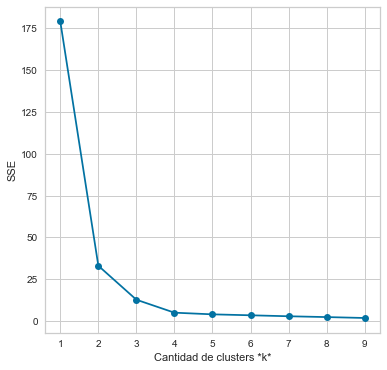

In [99]:
# Ejecuto el algoritmo con K entre 2 y 10 y guardo el error para luego graficarlo.
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df_kmeans_scaled)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters *k*')
plt.grid(True)
plt.ylabel('SSE')

In [100]:
list_k = list(range(2, 10))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_kmeans_scaled)
    centers = clusterer.cluster_centers_

    score = silhouette_score (df_kmeans_scaled, preds)
    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

For n_clusters =2 silhouette score is 0.74839926
For n_clusters =3 silhouette score is 0.7627148
For n_clusters =4 silhouette score is 0.77319044
For n_clusters =5 silhouette score is 0.77654326
For n_clusters =6 silhouette score is 0.7343505
For n_clusters =7 silhouette score is 0.7383762
For n_clusters =8 silhouette score is 0.57695657
For n_clusters =9 silhouette score is 0.5348495


Observamos que claramente las mejores métricas se obtienen con K=4, lo cual concuerda con la cantidad de clases de la condición de válvula en el dataset. Graficamos los clúster obtenidos, comparando con las etiquetas reales.

In [101]:
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, random_state=0
)

y_km = km.fit_predict(df_kmeans_scaled)

In [102]:
y_real =  LabelEncoder().fit_transform(y_train['ValveCondition'])

real_to_kmeans_classes_map = {0:statistics.mode(y_km[y_real==0]), \
                              1:statistics.mode(y_km[y_real==1]), \
                              2:statistics.mode(y_km[y_real==2]), \
                              3:statistics.mode(y_km[y_real==3])}

y_real = np.array([real_to_kmeans_classes_map[i] for i in y_real])

y_km_correct = (y_km == y_real)
y_km_incorrect = (y_km != y_real)

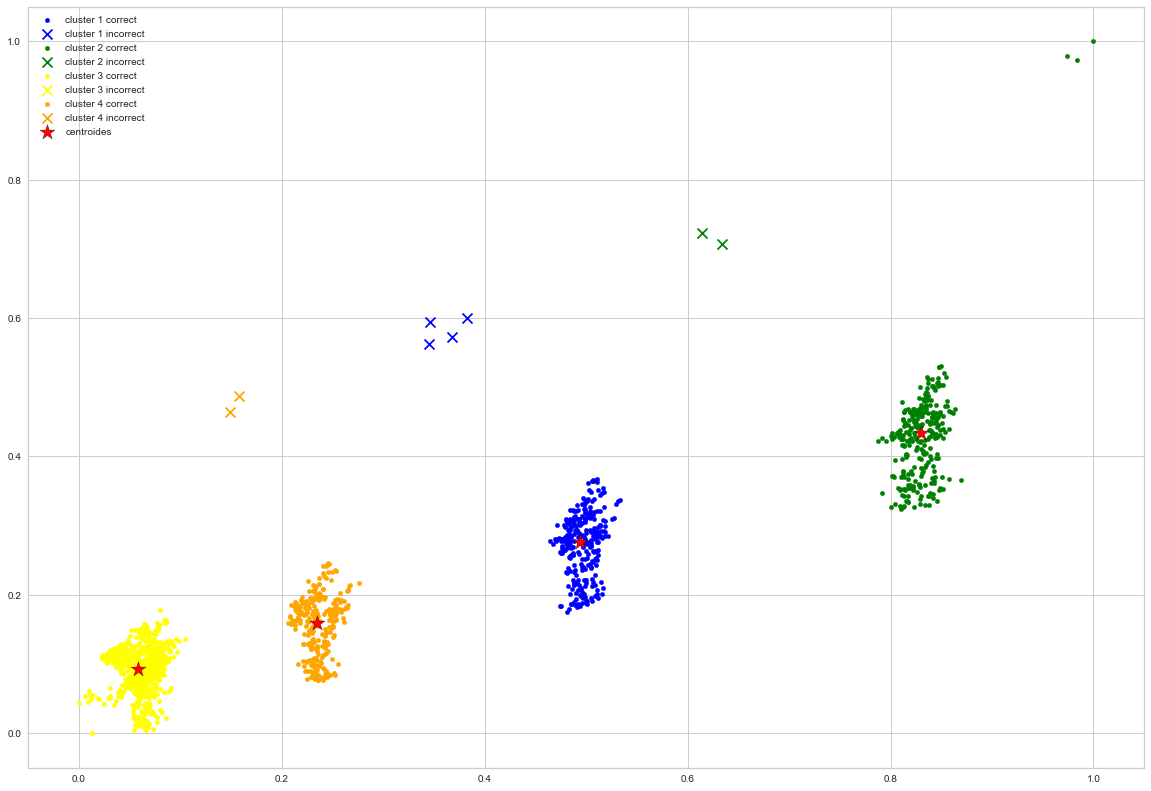

In [103]:
plt.figure(figsize=(20,14))

colors=['blue','green', 'yellow', 'orange']

for i,classes in enumerate(np.unique(y_km)):
    
    plt.scatter(
        df_kmeans_scaled[(y_km == classes) & (y_km_correct), 0], df_kmeans_scaled[(y_km == classes) & (y_km_correct), 1],
        s=20, c=colors[i],
        label=f'cluster {i+1} correct'
    )
    
    plt.scatter(
        df_kmeans_scaled[(y_km == classes) & (y_km_incorrect), 0], df_kmeans_scaled[(y_km == classes) & (y_km_incorrect), 1],
        s=100, c=colors[i], marker='x',
        label=f'cluster {i+1} incorrect'
    )
    
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroides'
)


plt.legend(scatterpoints=1)
#hace una grilla en el grafico
plt.grid(True)
#lo imprime en pantalla
plt.show()

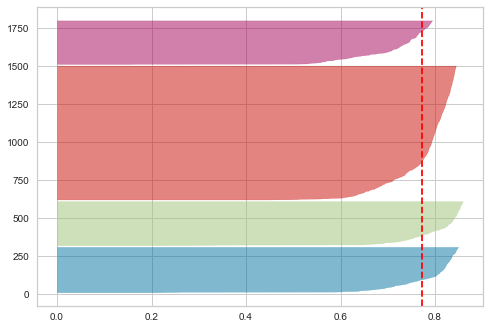

In [104]:
# Ploteo el gráfico de silueta
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(df_kmeans_scaled)                                          # Entreno el visualizador con datos
plt.grid(True)

**Observamos que la elección de features fue muy buena para este problema y Kmeans descubre y agrupa prácticamente en forma perfecta los 4 grupos**